In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import requests
from scipy import stats
import os, datetime
%matplotlib inline
import altair as alt



In [2]:
try:
    with open("airquality-config.json") as f:
        data = json.load(f)
        webcom_database = data['webcom_database']
        location = data['location']
        timezone = data['timezone']
except:
    print("###")
    print("###")
    print("###")
    print('### to run the notebook locally, setup an airquality-config.json file from the example')
    print("###")
    print("###")
    print("###")

print("configuration loaded")

configuration loaded


In [3]:
try:
    secrets_path=secretsPath
except:
    secrets_path='airquality-secrets.json'

print("loading secrets from "+secrets_path)

loading secrets from airquality-secrets.json


In [4]:

try:
    with open(secrets_path) as f:
        data = json.load(f)
        webcom_key = data['webcom_key']
except:
    print("###")
    print("###")
    print("###")
    print('### to run the notebook locally, setup an '+secrets_path+' file from the example')
    print("###")
    print("###")
    print("###")

print("secrets loaded")

secrets loaded


In [5]:
print("running with the following parameters:")
print("- webcom_database: "+webcom_database)
print("- location: "+location)
print("- webcom_key (length): "+str(len(webcom_key)))


running with the following parameters:
- webcom_database: airquality
- location: juvisy
- webcom_key (length): 40


In [6]:

r = requests.get('https://io.datasync.orange.com/datasync/v2/'+webcom_database+'/data/'+location,
                 headers={"content-type":"application/json",
                          "Authorization": "Bearer "+webcom_key})
json_content = r.json()
#print(json.dumps(json_content, indent=2))
print ("size of the loaded json: " +str(len(json.dumps(json_content))/1024) +"K")



size of the loaded json: 2928.396484375K


In [7]:
data = []
for year in json_content:
    #print(year)
    for month in json_content[year]:
        #print(month)
        for day in json_content[year][month]:
            #print(day)
            for measure in json_content[year][month][day]:
                #print(measure)
                data.append( json_content[year][month][day][measure])

data = sorted(data, key=lambda d: d['ts'])
#print(json.dumps(data, indent=2))
print(pd.DataFrame(data).tail())

       pm_10_0  pm_1_0  pm_2_5             ts
34291        0       0       0  1603699347109
34292        0       0       0  1603699748676
34293        0       0       0  1603700150245
34294        0       0       0  1603700551548
34295        3       0       0  1603700953279


In [21]:

#df = pd.read_json( json.dumps(json_content), orient='index', convert_dates=['ts'], date_unit='ms')
df = pd.read_json( json.dumps(data),  convert_dates=['ts'], date_unit='ms')
#df.ts = df.index.tz_localize('GMT', ambiguous='NaT')
#df.ts.dt.tz_localize('GMT', ambiguous='NaT').tz_convert('America/New_York')


df = df.set_index('ts')
df.index = df.index.tz_localize('UTC', ambiguous='NaT').tz_convert(timezone)

print(df.tail())


                                  pm_10_0  pm_1_0  pm_2_5
ts                                                       
2020-10-26 09:02:27.109000+01:00        0       0       0
2020-10-26 09:09:08.676000+01:00        0       0       0
2020-10-26 09:15:50.245000+01:00        0       0       0
2020-10-26 09:22:31.548000+01:00        0       0       0
2020-10-26 09:29:13.279000+01:00        3       0       0


In [22]:
df.pm_2_5.tail(10).mean()

0.0

In [23]:
stats.gmean(df[df.pm_2_5>0].pm_2_5.tail(10))

2.0476725110792193

<AxesSubplot:xlabel='ts'>

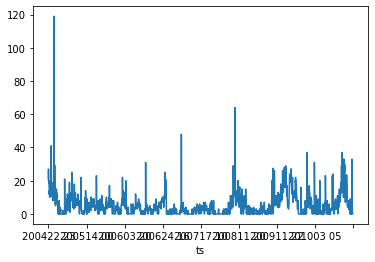

In [24]:
df.groupby([df.index.strftime('%y%m%d %H')]).pm_2_5.median().plot()

<AxesSubplot:xlabel='ts'>

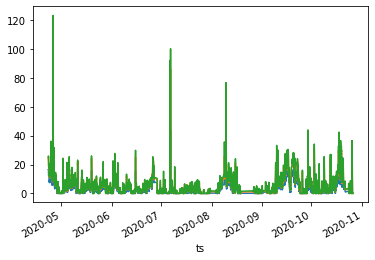

In [25]:
df.pm_1_0.rolling(10).mean().plot()
df.pm_2_5.rolling(10).mean().plot()
df.pm_10_0.rolling(10).mean().plot()


In [26]:
import tempfile

try:
    output_dir = os.environ['GITHUB_WORKSPACE'] + '/output'
except KeyError:
    output_dir = tempfile.gettempdir()+'/jupyter/airquality'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print('saving chart in '+output_dir)


saving chart in /tmp/jupyter/airquality


In [27]:
#alt.data_transformers.enable('json')

#convert data to the better format for altair (ts,pm_1_0,pm_2_5, pm_10_0) => (ts,particle,value)
long_form_data=df.reset_index().melt('ts', var_name='particle', value_name='value')

def print_graph(graph_type, hours):

    data=long_form_data

    previous_data = data

    if hours>0:
        data.ts = data.ts.dt.tz_localize(None, ambiguous='NaT')
        delta=datetime.timedelta(hours=hours)
        date_before = datetime.datetime.now() - delta
        data=data[data.ts.between(date_before, datetime.datetime.now())].copy()


        previous_data = long_form_data.copy()
        previous_data.ts = previous_data.ts + delta
        previous_data=previous_data[previous_data.ts.between(date_before, datetime.datetime.now())]

        data.ts = data.ts.dt.tz_localize(timezone, ambiguous='NaT')
        previous_data.ts = previous_data.ts.dt.tz_localize(timezone, ambiguous='NaT')


    max_value = max( data.value.max(), previous_data.value.max())
    data['max_value'] = max_value

    # save the data locally for display inside jupyer, the html graph will reference this 'local' json
    url = 'data-' + location + '-' + graph_type + '.json'
    data.to_json(url, orient='records')

    previous_url = 'data-' + location + '-' + graph_type + '-previous.json'
    previous_data.to_json(previous_url, orient='records')

    click = alt.selection_multi(encodings=['color'])

    points = alt.Chart(url).mark_point().encode(
        alt.X('ts:T', title='date'),
        y=alt.Y('value:Q',
                scale=alt.Scale(domain=(0,max(100, max_value))),
                axis=alt.Axis(title='particle count')),
        color='particle:N',
        size=alt.value(1),
        tooltip=['monthdate(ts):T','hoursminutes(ts):T','particle:N','value:Q'],
    ).properties(
        title='@'+location+' last '+graph_type,
        width=800,
        height=500
    ).transform_filter(
        click
    ).interactive()

    line = alt.Chart(url).mark_line().encode(
      x='ts:T',
      y='value:Q',
      color='particle:N',
      strokeDash='particle:N',
      size=alt.value(3),
    ).transform_window(
        moving_avg='mean(value)',
        frame=[-3, 2],
        sort=[alt.SortField("ts","ascending")],
        groupby=['particle']
    ).encode(
        x='ts:T',
        y='moving_avg:Q'
    ).transform_filter(
        click
    )


    if hours>0:
        previous_line = alt.Chart(previous_url).mark_line(opacity=0.3).encode(
          x='ts:T',
          y='value:Q',
          color='particle:N',
          strokeDash='particle:N',
          size=alt.value(3),
        ).transform_window(
            moving_avg='mean(value)',
            frame=[-3, 2],
            sort=[alt.SortField("ts","ascending")],
            groupby=['particle']
        ).encode(
            x='ts:T',
            y='moving_avg:Q'
        ).transform_filter(
            click
        )

        #waiting for https://github.com/vega/vega/issues/2365
#     print (max_value/1000.0)
#     area = alt.Chart(url).mark_area(
#         opacity=0.5,
#         color=alt.Gradient(
#             gradient='linear',
#             stops=[
#                    alt.GradientStop(color='#009966', offset=0.001),
#                    alt.GradientStop(color='#ffde33', offset=0.050),
#                    alt.GradientStop(color='#ff9933', offset=0.100),
#                    alt.GradientStop(color='#e81111', offset=0.150),
#                    alt.GradientStop(color='#660099', offset=0.200),
#                    alt.GradientStop(color='#7e0023', offset=0.300),
#                   ],
#             x1=0,
#             x2=0,
#             y1=max_value/1000.0,
#             y2=0
#         )
#       ).encode(
#         x='ts:T',
#         y='max_value:Q',
#     )

    legend = alt.Chart(url).mark_rect().encode(
        y=alt.Y('particle:N', axis=alt.Axis(title='Particle type')),
        color=alt.condition(click, 'particle:N',
                            alt.value('lightgray'),
                            legend=None),
        size=alt.value(250)
    ).properties(
        selection=click
    )


    if hours>0:
        chart = (points +line + previous_line) | legend
    else:
        chart = (points + line) | legend

    chart = chart.configure_title(
        fontSize=20,
    )


    if hours>0:
        previous_data.to_json(output_dir+'/'+previous_url, orient='records')
    data.to_json(output_dir+'/'+url, orient='records')
    chart.save(output_dir+'/airquality-'+location+'-'+graph_type+'.html')

    return chart



In [15]:
print_graph('48H', 48)

alt.HConcatChart(...)

In [16]:
print_graph('month', 24*30)

AmbiguousTimeError: 2020-10-25 02:02:47.578000

In [ ]:
print_graph('year', 24*30)